# Filter 1: Ligand-Based Virtual Screening (LBVS). Multi-Query Similarity Search for α2A-Selective GABA-A Modulators.

## Final Project: In Silico Identification of Novel α2-selective Positive Allosteric Modulators (PAMs) for GABA-A Receptors in Anxiety Treatment

**Student:** Pablo Rodríguez López.    
**Course**: Computational Structural Biology for Lead Discovery.   
**University**: Polytechnic University of Madrid.    
**Date:** January 2026.   
**Objective:** Screen the drug-like ChEMBL library (Screening Dataset) for compounds chemically similar to α2A-selective GABA-A modulators (Training Dataset) using multi-query Tanimoto similarity.

---

## 1. Library Setup and Configuration

Import required libraries and configure environment for fingerprint calculation and similarity searching.

In [1]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

!pip install rdkit -q
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors

# CONFIGURE VISUALIZATION
np.random.seed(42)
plt.rcParams['axes.labelweight'] = 'bold'
sns.set_style('whitegrid')

print('=' * 70)
print('FILTER 1: LIGAND-BASED VIRTUAL SCREENING (LBVS)')
print('=' * 70)
print(' All libraries imported successfully')
print(f' RDKit version: {Chem.rdBase.rdkitVersion}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 19.3 MB/s eta 0:00:00
FILTER 1: LIGAND-BASED VIRTUAL SCREENING (LBVS)
 All libraries imported successfully
 RDKit version: 2025.09.3


## 2. LBVS Methodology & Library Justification

### Why Morgan Fingerprints?

Gold standard for ligand similarity:
- **Circular topology**
- **Radius=2**
- **Fast computation**
- **Proven in industry**

### Why Tanimoto Similarity?

- **Symmetric** (similar(A,B) = similar(B,A))
- **Fragment-size normalized**
- **Interpretable threshold** (~0.85 = highly similar, ~0.5 = moderate, < 0.3 = dissimilar)
- **Computationally efficient** (suitable for 10k+ compound libraries: our case)

### Why Multi-Query?

Instead of searching with a single reference compound, we use **all 22 α2-selective compounds from our Training Set as queries**:
- **Captures chemical diversity**
- **For each screening compound**: take the **maximum similarity** across all 97 queries
- **Result**: enriched for compounds similar to ANY of our training actives

## 3. Load Input Data

In [2]:
print('\n' + '=' * 70)
print('LOADING INPUT DATA')
print('=' * 70)

# LOAD SCREENING LIBRARY (drug-like ChEMBL compounds)
print(f'\nLoading screening library...')
screening = pd.read_csv('Screening_set_chembl_druglike.csv')
# Change column 'ChemblID' for 'ChEMBL_ID'
screening.rename(columns={'ChEMBLID': 'ChEMBL_ID'}, inplace=True)
print(f'    Screening library: {len(screening):,} compounds')
print(f'    Columns: {", ".join(screening.columns)}')

# LOAD TRAINING SET (α2A-selective compounds ONLY)
print(f'\nLoading α2A-selective training set...')
training = pd.read_csv('Training_set_alpha2_selective.csv')
# Change column 'canonical_smiles' for 'SMILES'
training.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)
print(f'    Training set: {len(training):,} compounds')
print(f'    Columns: {", ".join(training.columns)}')

# LOAD FULL TRAINING SET (for PCA visualization with labels)
print(f'\nLoading full training set...')
training_full = pd.read_csv('Training_set_complete.csv')
# Change column 'canonical_smiles' for 'SMILES'
training_full.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)
print(f'    Full training set: {len(training_full):,} compounds')
print(f'    Columns: {", ".join(training_full.columns)}')


LOADING INPUT DATA

Loading screening library...
    Screening library: 30,359 compounds
    Columns: ChEMBL_ID, SMILES, MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings

Loading α2A-selective training set...
    Training set: 22 compounds
    Columns: SMILES, Ki_alpha1, Ki_alpha2, ChEMBL_ID, log2_ratio, refined_label, pKi_alpha1, pKi_alpha2

Loading full training set...
    Full training set: 502 compounds
    Columns: SMILES, Ki_alpha1, Ki_alpha2, ChEMBL_ID, log2_ratio, refined_label, pKi_alpha1, pKi_alpha2


In [3]:
screening.head()

,ChEMBL_ID,SMILES,MW,LogP,HBA,HBD,RotBonds,TPSA,AromaticRings
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.754,2.11362,5,1,3,84.82,3
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.319,1.33190,6,1,3,108.61,3
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.797,2.27274,5,2,3,87.98,3
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.309,1.46022,5,1,3,84.82,3
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.754,2.11362,5,1,3,84.82,3


Note: the 'SMILES' column in the screening library are already canonical SMILES.

## 4. Generate Morgan Fingerprints (ECFP4)

Convert SMILES to bit vectors for similarity calculation.

In [4]:
print('\n' + '=' * 70)
print('FINGERPRINT GENERATION (MORGAN, RADIUS=2)')
print('=' * 70)

def smiles_to_fingerprint(smiles, radius=2, nbits=2048):
    """Convert SMILES to Morgan fingerprint bit vector.

    Parameters:
        smiles: SMILES string
        radius: Morgan fingerprint radius (2 = ECFP4)
        nbits: Number of bits in fingerprint

    Returns:
        Fingerprint bit vector or None if invalid SMILES
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
    except:
        return None

# SCREENING LIBRARY FINGERPRINTS
print(f'\n Generating fingerprints for screening library ({len(screening):,} compounds)...')
fps_screening = [smiles_to_fingerprint(smi) for smi in screening['SMILES']]
valid_screening = sum(1 for fp in fps_screening if fp is not None)
print(f'   ✓ Valid fingerprints: {valid_screening:,}')

# TRAINING SET FINGERPRINTS (α2A-selective only)
print(f'\n Generating fingerprints for training set ({len(training):,} α2A-selective compounds)...')
fps_training = [smiles_to_fingerprint(smi) for smi in training['SMILES']]
valid_training = sum(1 for fp in fps_training if fp is not None)
print(f'   ✓ Valid fingerprints: {valid_training:,}')

# FULL TRAINING SET FINGERPRINTS (for PCA)
print(f'\n Generating fingerprints for full training set ({len(training_full):,} all compounds)...')
fps_full = [smiles_to_fingerprint(smi) for smi in training_full['SMILES']]
valid_full = sum(1 for fp in fps_full if fp is not None)
print(f'   ✓ Valid fingerprints: {valid_full:,}')


FINGERPRINT GENERATION (MORGAN, RADIUS=2)

 Generating fingerprints for screening library (30,359 compounds)...


Se han truncado las últimas 5000 líneas del flujo de salida.
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGenerator
[23:06:04] DEPRECATION WARNING: please use MorganGener

   ✓ Valid fingerprints: 30,359

 Generating fingerprints for training set (22 α2A-selective compounds)...
   ✓ Valid fingerprints: 22

 Generating fingerprints for full training set (502 all compounds)...
   ✓ Valid fingerprints: 502


[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerator
[23:06:08] DEPRECATION WARNING: please use MorganGenerat

The warnings make kind of difficult to check that the fingerprint generation went well, so we can check it with this quick summary:

In [5]:
# Summary:
print(f'\n' + '=' * 70)
print('FINGERPRINT GENERATION SUMMARY')
print('=' * 70)
print(f'\n Generated fingerprints for screening library ({len(screening):,} compounds)')
print(f'   ✓ Valid fingerprints: {valid_screening:,}')
print(f'\n Generated fingerprints for Training set (alpha2-selective) ({len(training):,} compounds)')
print(f'   ✓ Valid fingerprints: {valid_training:,}')
print(f'\n Generated fingerprints for Training set (complete) ({len(training_full):,} compounds)')
print(f'   ✓ Valid fingerprints: {valid_full:,}')


FINGERPRINT GENERATION SUMMARY

 Generated fingerprints for screening library (30,359 compounds)
   ✓ Valid fingerprints: 30,359

 Generated fingerprints for Training set (alpha2-selective) (22 compounds)
   ✓ Valid fingerprints: 22

 Generated fingerprints for Training set (complete) (502 compounds)
   ✓ Valid fingerprints: 502


All fingerprints were successfully generated.

## 5. Multi-Query Similarity Search

For each screening compound, calculate Tanimoto similarity against all 22 α2A-selective training compounds, keeping the **maximum similarity** as the screening score.

In [6]:
print('\n' + '=' * 70)
print('MULTI-QUERY SIMILARITY SEARCH')
print('=' * 70)

# MULTI-QUERY TANIMOTO SEARCH
print(f'\nCalculating Tanimoto similarity for {len(screening):,} screening compounds')
print(f'against {len(training):,} α2A-selective queries...\n')

similarity_scores = []

for i, fp_screen in enumerate(fps_screening):
    # Skip invalid fingerprints
    if fp_screen is None:
        similarity_scores.append(0.0)
        continue

    # Calculate similarity against all training compounds
    max_similarity = 0.0
    for fp_train in fps_training:
        if fp_train is not None:
            sim = DataStructs.TanimotoSimilarity(fp_screen, fp_train)
            if sim > max_similarity:
                max_similarity = sim

    similarity_scores.append(max_similarity)

    # Progress update every 1000 compounds
    if (i + 1) % 1000 == 0:
        print(f'  Processed: {i + 1:,} / {len(screening):,}')

print(f'  Processed:  {len(screening):,} / {len(screening):,}')
print(f'\nSimilarity calculation complete')

# ADD SIMILARITY SCORES TO SCREENING DATAFRAME
screening['Similarity_Max'] = similarity_scores

print(f'\nSimilarity Score Distribution:')
print(f'  Min: {screening["Similarity_Max"].min():.3f}')
print(f'  Max: {screening["Similarity_Max"].max():.3f}')
print(f'  Mean: {screening["Similarity_Max"].mean():.3f}')
print(f'  Median: {screening["Similarity_Max"].median():.3f}')


MULTI-QUERY SIMILARITY SEARCH

Calculating Tanimoto similarity for 30,359 screening compounds
against 22 α2A-selective queries...

  Processed: 1,000 / 30,359
  Processed: 2,000 / 30,359
  Processed: 3,000 / 30,359
  Processed: 4,000 / 30,359
  Processed: 5,000 / 30,359
  Processed: 6,000 / 30,359
  Processed: 7,000 / 30,359
  Processed: 8,000 / 30,359
  Processed: 9,000 / 30,359
  Processed: 10,000 / 30,359
  Processed: 11,000 / 30,359
  Processed: 12,000 / 30,359
  Processed: 13,000 / 30,359
  Processed: 14,000 / 30,359
  Processed: 15,000 / 30,359
  Processed: 16,000 / 30,359
  Processed: 17,000 / 30,359
  Processed: 18,000 / 30,359
  Processed: 19,000 / 30,359
  Processed: 20,000 / 30,359
  Processed: 21,000 / 30,359
  Processed: 22,000 / 30,359
  Processed: 23,000 / 30,359
  Processed: 24,000 / 30,359
  Processed: 25,000 / 30,359
  Processed: 26,000 / 30,359
  Processed: 27,000 / 30,359
  Processed: 28,000 / 30,359
  Processed: 29,000 / 30,359
  Processed: 30,000 / 30,359
  Proce

In [7]:
#Check shape of the screening dataset again
screening.shape

(30359, 10)


Generating similarity distribution plot...


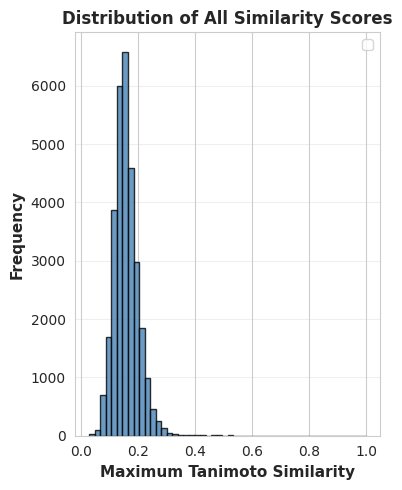

In [8]:
print('\nGenerating similarity distribution plot...')

fig, ax = plt.subplots(1, 1, figsize=(4, 5))

# HISTOGRAM OF ALL SIMILARITY SCORES
ax.hist(screening['Similarity_Max'], bins=50, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Maximum Tanimoto Similarity', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of All Similarity Scores', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

At least one compound was found with a max similarity of 1.0. This reminds us that it is possible to find in chembl compounds present in our training set. Since these compounds will be docked anyways at the end of the pipeline, we don't want them in our screening set. Therefore. We now remove from the screening set those compounds with a SMILES identical to any of the SMILES in the training set:

In [9]:
# Store the shape of the screening dataset
before = screening.shape[0]

# Remove compounds with the same SMILES as the training set
for smiles in training['SMILES']:
    screening = screening[screening['SMILES'] != smiles]

# Now print the current size and the number of compounds lost (if any)
after = screening.shape[0]
lost = before - after
print(f'\nRemoved {lost:,} compounds with the same SMILES as the training set')
print(f'New screening library size: {after:,}')


Removed 1 compounds with the same SMILES as the training set
New screening library size: 30,358


## 6. Select LBVS Hits with Similarity Threshold

Filter compounds by similarity threshold. Standard cutoff is usually **0.5 (moderate similarity)** to capture structural diversity while maintaining relevance. However, in this case we have an average similarity of 0.167. Thus, we cannot be so strict. Looking at the histrogram we should cut around 0.3 to get enough compounds for downstream filters. We thus lower the threshold to 0.3.

In [10]:
print('\n' + '=' * 70)
print('FILTERING LBVS HITS')
print('=' * 70)

# SIMILARITY THRESHOLD
THRESHOLD = 0.3
print(f'\nApplying similarity threshold: {THRESHOLD}')

# FILTER HITS
lbvs_hits = screening[screening['Similarity_Max'] >= THRESHOLD].copy().reset_index(drop=True)
# order by Similarity_Max
lbvs_hits = lbvs_hits.sort_values(by='Similarity_Max', ascending=False).reset_index(drop=True)

print(f'\nHits with Tanimoto ≥ {THRESHOLD}: {len(lbvs_hits):,} compounds')
print(f'   Percentage of screening library: {(len(lbvs_hits) / len(screening) * 100):.1f}%')

# DEDUPLICATE BY CANONICAL SMILES (ensure no duplicates)
print(f'\n2Deduplicating by canonical SMILES...')
before_dedup = len(lbvs_hits)
lbvs_hits = lbvs_hits.drop_duplicates(subset=['SMILES']).reset_index(drop=True)
print(f'   After deduplication: {len(lbvs_hits):,} compounds')
if before_dedup > len(lbvs_hits):
    print(f'   Removed: {before_dedup - len(lbvs_hits)} duplicates')


FILTERING LBVS HITS

Applying similarity threshold: 0.3

Hits with Tanimoto ≥ 0.3: 160 compounds
   Percentage of screening library: 0.5%

2Deduplicating by canonical SMILES...
   After deduplication: 160 compounds



Generating similarity distribution plot...
 Saved: 01_similarity_distribution.png


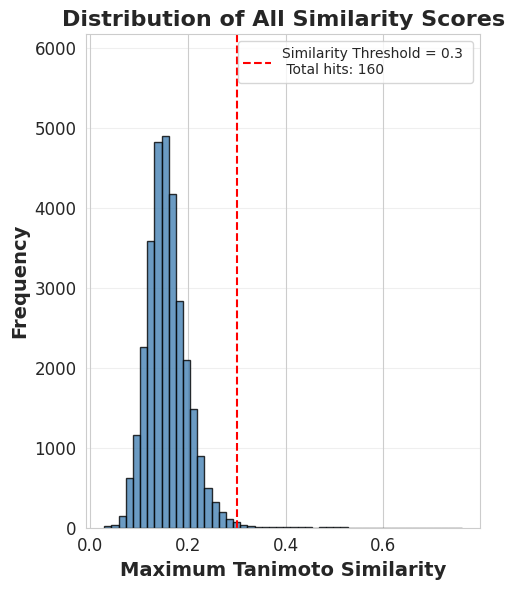

In [17]:
print('\nGenerating similarity distribution plot...')

fig, ax = plt.subplots(1, 1, figsize=(5, 6))

# HISTOGRAM OF ALL SIMILARITY SCORES
ax.hist(screening['Similarity_Max'], bins=50, color='steelblue', alpha=0.8, edgecolor='black')
ax.set_xlabel('Maximum Tanimoto Similarity', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
ax.set_title('Distribution of All Similarity Scores', fontsize=16, fontweight='bold')
# addjust tick label sizes
ax.tick_params(axis='both', labelsize=12)
#add vertical line for similarity threshold
ax.axvline(x=THRESHOLD, color='red', linestyle='--', label=f'Similarity Threshold = {THRESHOLD} \n Total hits: {len(lbvs_hits)}')
# legend including the threshold and the number of hits
ax.set_ylim(bottom=0, top=ax.get_ylim()[1]*1.2)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
# save fig
plt.savefig('01_similarity_distribution.png', dpi=300, bbox_inches='tight')
# print messsage of picture saved
print(' Saved: 01_similarity_distribution.png')
plt.show()

## 7. Export LBVS Hits

In [12]:
print('\n' + '=' * 70)
print('EXPORTING LBVS RESULTS')
print('=' * 70)

# EXPORT LBVS HITS
lbvs_hits.to_csv(f'LBVS_hits_filtered_{THRESHOLD}.csv', index=False)
print(f'\n Exported: LBVS_hits_filtered_{THRESHOLD}.csv')
print(f'  Entries: {len(lbvs_hits):,}')
print(f'  Columns: {", ".join(lbvs_hits.columns)}')

# EXPORT FULL SIMILARITY SCORES (for reference)
screening.to_csv('LBVS_all_similarity_scores.csv', index=False)
print(f'\n Exported: LBVS_all_similarity_scores.csv')
print(f'  Contains all screening compounds + similarity scores')


EXPORTING LBVS RESULTS

 Exported: LBVS_hits_filtered_0.3.csv
  Entries: 160
  Columns: ChEMBL_ID, SMILES, MW, LogP, HBA, HBD, RotBonds, TPSA, AromaticRings, Similarity_Max

 Exported: LBVS_all_similarity_scores.csv
  Contains all screening compounds + similarity scores


## 8. Chemical Space Analysis: PCA with Full Training Set

Project training compounds (colored by label) and LBVS hits into 2D chemical space using PCA of molecular descriptors. This allows us to:
- See how well PCA separates compounds based on their label
- See where our LBVS hits fall in the PCA

In [ ]:
print('\n' + '=' * 70)
print('PCA ANALYSIS: CHEMICAL SPACE VISUALIZATION')
print('=' * 70)

# HELPER FUNCTION: CALCULATE MOLECULAR DESCRIPTORS
def calculate_descriptors(smiles):
    """Calculate molecular descriptors from SMILES string.

    Parameters:
        smiles: SMILES string

    Returns:
        Dictionary with descriptor values or None if invalid SMILES
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return {
            'MW': Descriptors.ExactMolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'TPSA': Descriptors.TPSA(mol),
            'AromaticRings': Descriptors.NumAromaticRings(mol)
        }
    except:
        return None

# DESCRIPTOR COLUMNS FOR PCA
descriptor_cols = ['MW', 'LogP', 'HBA', 'HBD', 'RotBonds', 'TPSA', 'AromaticRings']

print(f'\n1 Preparing PCA data for full training set ({len(training_full):,} compounds)...')

# CALCULATE DESCRIPTORS FOR TRAINING_FULL (from SMILES)
print(f'   Calculating molecular descriptors from SMILES...')
descriptors_list = [calculate_descriptors(smi) for smi in training_full['SMILES']]

# Add descriptors to training_full
for key in descriptor_cols:
    training_full[key] = [d.get(key, np.nan) if d else np.nan for d in descriptors_list]

# ENSURE NO MISSING VALUES
training_full_clean = training_full.dropna(subset=descriptor_cols).copy()
print(f'    Valid compounds with descriptors: {len(training_full_clean):,}')

# STANDARDIZE DESCRIPTORS
print(f'\n Standardizing descriptors...')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(training_full_clean[descriptor_cols])
print(f'    Standardized {len(descriptor_cols)} descriptors')

# FIT PCA
print(f'\n Fitting PCA (2 components)...')
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f'    Explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}')
print(f'    Total: {sum(pca.explained_variance_ratio_):.1%}')

# ADD PCA COORDINATES TO TRAINING DATAFRAME
training_full_clean['PC1'] = X_pca[:, 0]
training_full_clean['PC2'] = X_pca[:, 1]

print(f'\n Projecting LBVS hits onto training set PCA space...')

# PROJECT LBVS HITS
lbvs_clean = lbvs_hits.dropna(subset=descriptor_cols).copy()
X_lbvs_scaled = scaler.transform(lbvs_clean[descriptor_cols])
X_lbvs_pca = pca.transform(X_lbvs_scaled)
lbvs_clean['PC1'] = X_lbvs_pca[:, 0]
lbvs_clean['PC2'] = X_lbvs_pca[:, 1]
print(f'    Projected {len(lbvs_clean):,} LBVS hits onto PCA space')



PCA ANALYSIS: CHEMICAL SPACE VISUALIZATION

1 Preparing PCA data for full training set (502 compounds)...
   Calculating molecular descriptors from SMILES...
    Valid compounds with descriptors: 502

 Standardizing descriptors...
    Standardized 7 descriptors

 Fitting PCA (2 components)...
    Explained variance: PC1=49.2%, PC2=19.2%
    Total: 68.3%

 Projecting LBVS hits onto training set PCA space...
    Projected 160 LBVS hits onto PCA space


almost 70% of variance is a pretty good result!


Generating combined PCA visualization...
   Found 5 unique labels: ['alpha1-selective', 'alpha2-selective', 'non-binding', 'pan-selective', 'weak-binder']
 Saved: 02_PCA_combined_training_lbvs_centroids.png


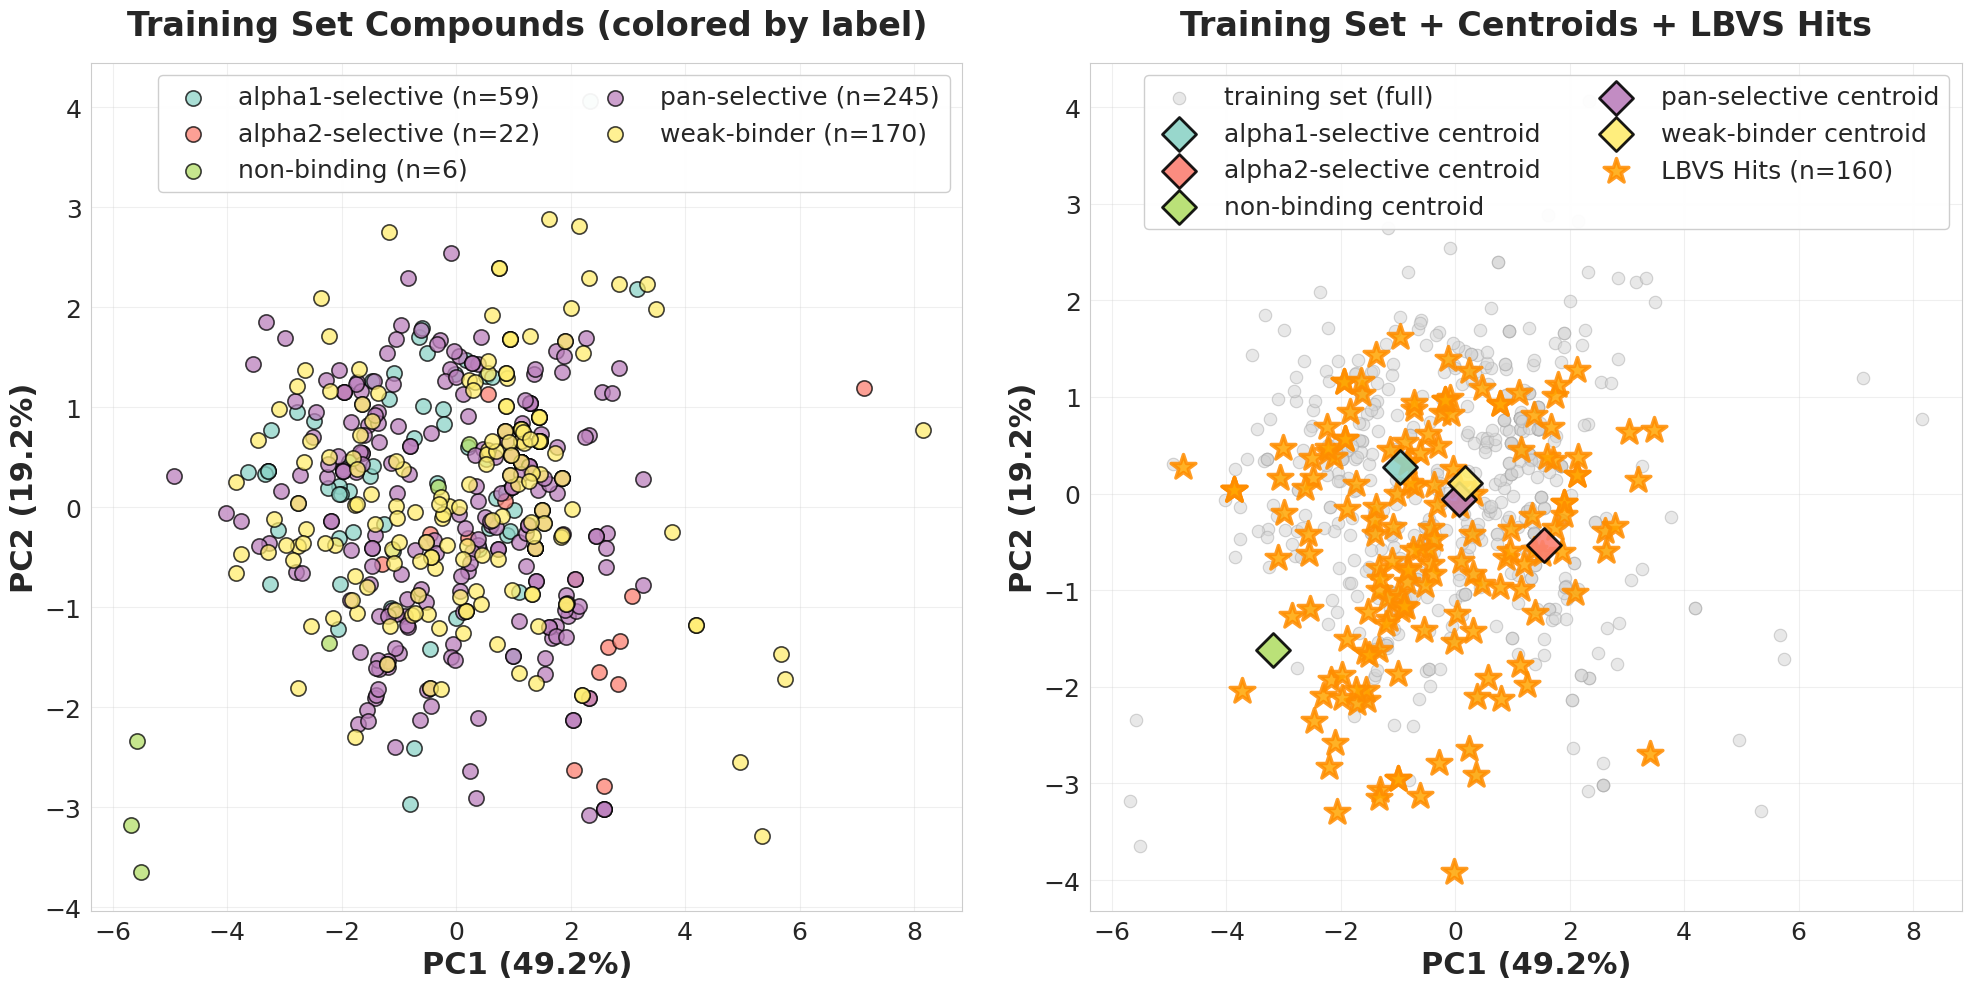

In [ ]:
## 9. Combined PCA Plot: Training Labels & LBVS Hits with Centroids

print('\nGenerating combined PCA visualization...')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# GET UNIQUE LABELS - EXPLICITLY USE 'label' COLUMN
label_col = 'refined_label'  # Explicitly specify the label column
if label_col not in training_full_clean.columns:
    # Fallback: check for other categorical columns
    possible_cols = ['Label', 'Activity', 'Class', 'Category']
    for col in possible_cols:
        if col in training_full_clean.columns:
            label_col = col
            break

labels = sorted(training_full_clean[label_col].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
color_map = {label: colors[i] for i, label in enumerate(labels)}

print(f'   Found {len(labels)} unique labels: {labels}')

# SUBPLOT 1: Training set colored by label (original Plot 1)
for label in labels:
    mask = training_full_clean[label_col] == label
    ax1.scatter(training_full_clean.loc[mask, 'PC1'],
                training_full_clean.loc[mask, 'PC2'],
                c=[color_map[label]], label=f'{label} (n={mask.sum()})',
                s=120, alpha=0.75, edgecolors='black', linewidth=1.2)

# Styling for subplot 1 (bigger everything)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=22, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=22, fontweight='bold')
ax1.set_title('Training Set Compounds (colored by label)', fontsize=24, fontweight='bold', pad=20)
ax1.legend(loc='best', fontsize=18, framealpha=0.95, ncols=2)
ax1.tick_params(labelsize=18)
ax1.grid(alpha=0.3)

# SUBPLOT 2: Gray training background + colored centroids + orange hits (enhanced Plot 2)
# Gray training points (all labels)
for label in labels:
    mask = training_full_clean[label_col] == label
    ax2.scatter(training_full_clean.loc[mask, 'PC1'],
                training_full_clean.loc[mask, 'PC2'],
                c='lightgray', s=80, alpha=0.5,
                edgecolors='darkgray', linewidth=0.8, label=f'training set (full) ' if label == labels[0] else "")

# Colored centroids for training labels
for label in labels:
    mask = training_full_clean[label_col] == label
    if mask.sum() > 0:
        centroid_pc1 = training_full_clean.loc[mask, 'PC1'].mean()
        centroid_pc2 = training_full_clean.loc[mask, 'PC2'].mean()
        ax2.scatter(centroid_pc1, centroid_pc2, c=[color_map[label]], s=300,
                    marker='D', alpha=0.9, edgecolors='black', linewidth=2,
                    label=f'{label} centroid',
                    zorder=10)

# Orange hits (different from training colors, bold diamonds)
ax2.scatter(lbvs_clean['PC1'], lbvs_clean['PC2'],
            c='orange', s=350, alpha=0.85, marker='*',
            label=f'LBVS Hits (n={len(lbvs_clean)})',
            edgecolors='darkorange', linewidth=2.5, zorder=5)

# Styling for subplot 2 (matching bigger style)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=22, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=22, fontweight='bold')
ax2.set_title('Training Set + Centroids + LBVS Hits', fontsize=24, fontweight='bold', pad=20)
ax2.legend(loc='best', fontsize=18, framealpha=0.95, ncols=2)
ax2.tick_params(labelsize=18)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('02_PCA_combined_training_lbvs_centroids.png', dpi=300, bbox_inches='tight', facecolor='white')
print(' Saved: 02_PCA_combined_training_lbvs_centroids.png')
plt.show()

Figure 1. Principal component analysis of the full training set (n=502 compounds) colored by selectivity and activity profile. The first two components explain 68.4% of variance (PC1: 49.2%, PC2: 19.2%). Key observations: (1) α2A-selective compounds (red, n=22) cluster primarily in the central-left region (PC1: -2 to +1), showing a significant overlap with pan-selective compounds (purple, n=245). (2) α1-selective compounds (blue, n=59) spread across the entire chemical space, suggesting a higher structural diversity. (3) Non-binding (green, n=6) and weak-binder (yellow, n=170) compounds also greatly overlap with previous groups. Overall, no group seems to be properly clustered, which reflexts the great hidden complexity of the chemical space.

Figure 2. LBVS hits (n=160, red stars) projected onto the training set chemical space. Hits spread across all regions which was expected considering the previous results. Thus, we cannot conclude much about the success / failure of this LBVS analysis.

## 11. Final Summary & Next Steps

In [ ]:
print('\n' + '=' * 70)
print('FILTER 1 (LBVS) COMPLETE')
print('=' * 70)

print(f'\n SCREENING SUMMARY')
print(f'   Screening library size: {len(screening):,} compounds')
print(f'   Training queries (α2A-selective): {len(training):,} compounds')
print(f'   Method: Multi-query with Tanimoto Similarity Score')
print(f'   Similarity threshold: {THRESHOLD}')

print(f'\n RESULTS')
print(f'   LBVS hits: {len(lbvs_hits):,} compounds')
print(f'   Hit rate: {(len(lbvs_hits) / len(screening) * 100):.1f}%')
print(f'   Avg similarity (hits): {lbvs_hits["Similarity_Max"].mean():.3f}')
print(f'   Std Dev: {lbvs_hits["Similarity_Max"].std():.3f}')

print(f'\n OUTPUT FILES')
print(f'   1. LBVS_hits_filtered.csv - {len(lbvs_hits):,} compounds for Filter 2')
print(f'   2. LBVS_all_similarity_scores.csv - Full screening data')
print(f'   3. 01_similarity_distribution.png - Similarity score distribution')
print(f'   4. 02_PCA_combined_training_lbvs_centroids.png - PCA analysis')

print(f'\n NEXT STEP: Filter 2 - Pharmacophore Screening')
print(f'   Input: LBVS_hits_filtered.csv ({len(lbvs_hits):,} compounds)')

print(f'\n' + '=' * 70)


FILTER 1 (LBVS) COMPLETE

 SCREENING SUMMARY
   Screening library size: 30,358 compounds
   Training queries (α2A-selective): 22 compounds
   Method: Multi-query with Tanimoto Similarity Score
   Similarity threshold: 0.3

 RESULTS
   LBVS hits: 160 compounds
   Hit rate: 0.5%
   Avg similarity (hits): 0.371
   Std Dev: 0.083

 OUTPUT FILES
   1. LBVS_hits_filtered.csv - 160 compounds for Filter 2
   2. LBVS_all_similarity_scores.csv - Full screening data
   3. 01_similarity_distribution.png - Similarity score distribution
   4. 02_PCA_combined_training_lbvs_centroids.png - PCA analysis

 NEXT STEP: Filter 2 - Pharmacophore Screening
   Input: LBVS_hits_filtered.csv (160 compounds)

